# Support Vector Machine

In [1]:
import random
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from util import data_utils

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# import autoreload
# ?autoreload

## Load CIFAR-10 and preprocess

Convert images to zero mean 1-D array, along with the bias trick.


In [23]:
cifar10_root = 'util/datasets/cifar-10-batches-py'
data = data_utils.load_CIFAR10(cifar10_root)

In [78]:
def shape(*args):
    for item in args:
        print(item.shape)

Xtrain, ytrain, Xtest, ytest = data

# split into training, testing, validation, development
num_training = 49000
num_test = 1000
num_val = 1000
num_dev = 500

mask = range(num_training, num_training + num_val)
Xval = Xtrain[mask]
yval = ytrain[mask]

mask = range(num_training)
Xtrain = Xtrain[mask]
ytrain = ytrain[mask]

mask = np.random.choice(num_training, num_dev, replace=False)

Xdev = Xtrain[mask]
ydev = ytrain[mask]

mask = range(num_test)
Xtest = Xtest[mask]
ytest = ytest[mask]

# shape(Xtrain, Xval, Xdev, Xtest)

In [79]:
# Preprocessing: reshape the image data into rows
def reshape(*args):
    return [item.reshape(item.shape[0], -1) for item in args]

Xtrain, Xval, Xdev, Xtest = reshape(Xtrain, Xval, Xdev, Xtest)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


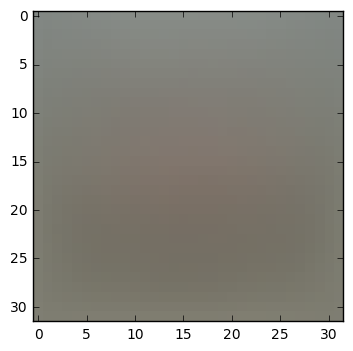

In [80]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(Xtrain, axis=0)
print(mean_image[:10])

plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()



In [81]:
# second: subtract the mean image from train and test data
Xtrain -= mean_image
Xval -= mean_image
Xtest -= mean_image
Xdev -= mean_image

In [82]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
Xtrain = np.hstack([Xtrain, np.ones((Xtrain.shape[0], 1))])
Xval = np.hstack([Xval, np.ones((Xval.shape[0], 1))])
Xtest = np.hstack([Xtest, np.ones((Xtest.shape[0], 1))])
Xdev = np.hstack([Xdev, np.ones((Xdev.shape[0], 1))])

## SVM Classifier

In [525]:
from classifiers.linear_svm import svm_loss_naive, svm_loss_vectorized
from util.gradient_check import grad_check_sparse
import time

W = np.random.randn(3073, 10) * 0.0001
loss, dW = svm_loss_vectorized(W, Xdev, ydev, 0.00001)

## Gradient Check
Verify computed analytic gradient with numerical gradient

In [526]:
loss, grad = svm_loss_vectorized(W, Xdev, ydev, 1e2)
f = lambda w: svm_loss_vectorized(w, Xdev, ydev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 3.119437 analytic: 3.119437, relative error: 7.018588e-12
numerical: -16.288553 analytic: -16.288553, relative error: 1.019887e-12
numerical: -9.833759 analytic: -9.833759, relative error: 5.080371e-12
numerical: -15.577749 analytic: -15.577749, relative error: 3.171221e-13
numerical: 8.604654 analytic: 8.604654, relative error: 3.368195e-12
numerical: 10.526249 analytic: 10.526249, relative error: 4.190270e-12
numerical: -1.361013 analytic: -1.377408, relative error: 5.987114e-03
numerical: 17.566968 analytic: 17.570734, relative error: 1.071956e-04
numerical: -12.502029 analytic: -12.502029, relative error: 1.918722e-12
numerical: 5.525339 analytic: 5.525339, relative error: 8.341051e-12


## Stocastic Gradient Descent

In [563]:
from classifiers.linear_classifier import LinearSVM

svm = LinearSVM()
loss_hist = svm.train(Xtrain, ytrain, learning_rate=1e-7, reg=5e+4, num_iters=1500, verbose=True)

iteration 0 / 1500: loss 787.6936094534642
iteration 100 / 1500: loss 285.03864450129754
iteration 200 / 1500: loss 106.77217002698472
iteration 300 / 1500: loss 42.09532722730197
iteration 400 / 1500: loss 18.78813212969706
iteration 500 / 1500: loss 10.302237102655255
iteration 600 / 1500: loss 6.409162678242714
iteration 700 / 1500: loss 6.490376373581723
iteration 800 / 1500: loss 5.69506665568257
iteration 900 / 1500: loss 5.4485277331524715
iteration 1000 / 1500: loss 5.772539941176782
iteration 1100 / 1500: loss 5.273019807655213
iteration 1200 / 1500: loss 5.670959954802687
iteration 1300 / 1500: loss 4.915260320838742
iteration 1400 / 1500: loss 4.591819077887667


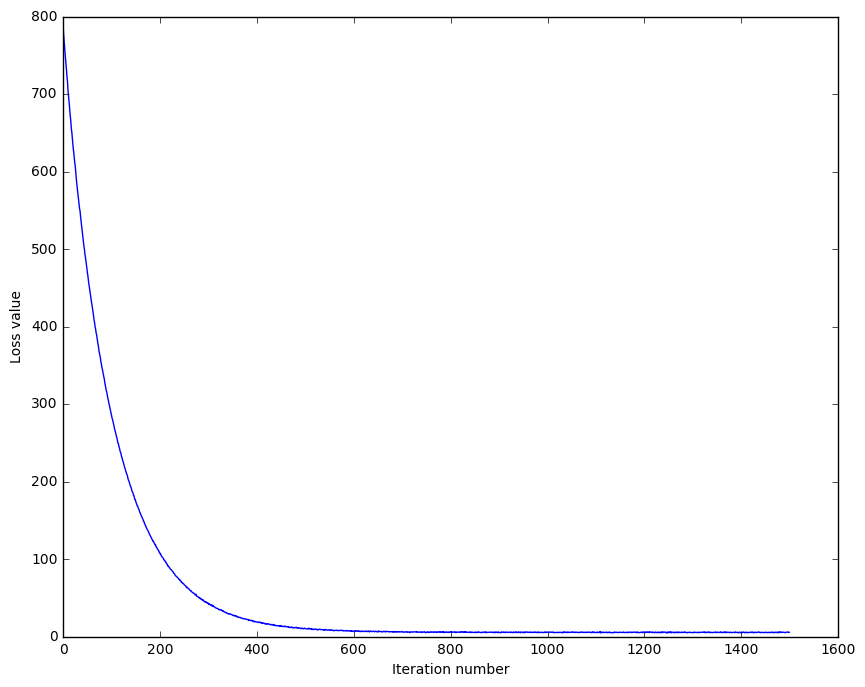

In [564]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [581]:
ytrainpred = svm.predict(Xtrain)
print('training accuracy: %f' % (np.mean(ytrain == ytrainpred),))
yvalpred = svm.predict(Xval)
print('validation accuracy: %f' % (np.mean(yval == yvalpred), ))

training accuracy: 0.367816
validation accuracy: 0.385000


## Vizualize results

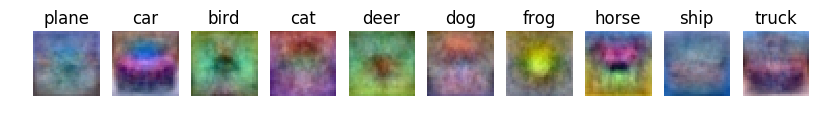

In [593]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(1, 10, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])